<a href="https://colab.research.google.com/github/AlwaysEden/Temperature-Forecast/blob/main/ForecastRecursive_with_RandomForestRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install skforecast


In [2]:
from os.path import split
import requests
import json
from datetime import datetime, timedelta
import pandas as pd
from zoneinfo import ZoneInfo
from re import X
import numpy as np
import time

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy.ndimage import gaussian_filter1d
from skforecast.recursive import ForecasterRecursive
from sklearn.ensemble import RandomForestRegressor

In [3]:
#Required - loc: 지역 지점 번호 (관련 자료는 기상청 지상종관관측 지점 번호 참고)
def weatherLatestData(loc, startDt, endDt):  #기상청API에서 온도 데이터를 받아 파싱
  now = datetime.now(ZoneInfo('Asia/Seoul'))

  #startDt = three_hours_ago.strftime("%Y%m%d%H00")
  #endDt = now.strftime(f"%Y%m%d%H00")
  #startDt = '202412090800'
  #endDt = "202501080800"
  print(startDt)
  print(endDt)

  # URL 문자열, stn=138(포항)
  url = 'https://apihub.kma.go.kr/api/typ01/url/kma_sfctm5.php?tm1={startDt}&tm2={endDt}&obs=TA&stn={loc}&help=0&authKey=[APIKEY]'.format(startDt=startDt, endDt=endDt, loc=loc)

  # GET 요청
  response = requests.get(url)
  print(response.status_code)
  if response.status_code != 200:
    return None

  print(response)
  splited_response = response.text.splitlines()
  print(splited_response)
  if len(splited_response) <= 4:
    return None

  result_lines = splited_response[3:len(splited_response) - 1]


  temperature_list = []
  for line in result_lines:
    line = line.split(',')
    temperature_list.append(float(line[5]))

  # 예제 시계열 데이터 생성
  date_rng = pd.date_range(start=startDt, end=endDt, freq='h')
  df = pd.DataFrame({'ds': date_rng, 'y': temperature_list})

  return df

#Required - loc: 지역 지점 번호 (관련 자료는 기상청 지상종관관측 지점 번호 참고)
def weatherPastData(loc):  #기상청API에서 온도 데이터를 받아 파싱
  now = datetime.now(ZoneInfo('Asia/Seoul'))
  one_month_ago = now - timedelta(days=30)

  startDt = one_month_ago.strftime("%Y%m%d%H00")
  endDt = now.strftime(f"%Y%m%d%H00")
  #startDt = '202412090800'
  #endDt = "202501080800"
  print(startDt)
  print(endDt)

  # URL 문자열, stn=138(포항)
  url = 'https://apihub.kma.go.kr/api/typ01/url/kma_sfctm5.php?tm1={startDt}&tm2={endDt}&obs=TA&stn={loc}&help=0&authKey=[APIKEY]'.format(startDt=startDt, endDt=endDt, loc=loc)

  # GET 요청
  response = requests.get(url)

  splited_response = response.text.splitlines()
  result_lines = splited_response[3:len(splited_response) - 1]

  temperature_list = []
  for line in result_lines:
    line = line.split(',')
    temperature_list.append(float(line[5]))

  # 예제 시계열 데이터 생성
  date_rng = pd.date_range(start=startDt, end=endDt, freq='h')
  df = pd.DataFrame({'ds': date_rng, 'y': temperature_list})

  return df

#Required- X: x좌표, Y: y좌표 (관련 자료는 기상청 단기예보 오픈 API 활용가이드 참고)
def weatherFutureData(X, Y): #x좌표, y좌표
  now = datetime.now(ZoneInfo('Asia/Seoul'))
  base_time = now.strftime("%H00")
  base_time = '0800'

  #base_time: 2시부터 3시간 간격으로 증가. (02, 05, 08, 11, 14...)
  if base_time == '0200' or base_time == '0500' or base_time == '0800' or base_time == '1100' or base_time == '1400' or base_time == '1700' or base_time == '2000' or base_time == '2300':
    base_date = now.strftime("%Y%m%d")

    # URL 문자열, numOfRows: 288(1일치, 12*24)
    url = f'https://apihub.kma.go.kr/api/typ02/openApi/VilageFcstInfoService_2.0/getVilageFcst?pageNo=1&numOfRows=288&dataType=JSON&base_date={base_date}&base_time={base_time}&nx={X}&ny={Y}&authKey=[APIKEY]'

    response = requests.get(url)

    json_response = response.json()

    future_tmp = []
    fcstTime = json_response['response']['body']['items']['item'][0]['fcstTime']
    for x in json_response['response']['body']['items']['item']:
      if x['category'] == 'TMP':
        future_tmp.append(round(float(x['fcstValue']),2))

    startDt = now.strftime("%Y%m%d") + fcstTime
    print(startDt)
    #startDt = '202501071200'
    date_rng = pd.date_range(start=startDt, periods=24, freq='h')
    df = pd.DataFrame({'ds': date_rng, 'external_param': future_tmp})
    return df

  return 0

In [4]:
#데이터 다운로드

weatherData = weatherPastData(138) #138 포항
factoryData = weatherPastData(184) #184 제주도

factoryData['y'] = factoryData['y'] + 5
factoryData['y'] = gaussian_filter1d(factoryData['y'], sigma=4) #제주도 데이터를 공장 현장데이터로 사용하려고하다보니 완만한 변화율이 필요했음.
factoryData['external_param'] = weatherData['y']

steps = 24 # 예측하고자하는 시간
factory_trainingData = factoryData.iloc[:(len(factoryData)-steps)]
factory_testData = factoryData.iloc[(len(factoryData)-steps):]

202412230900
202501220900
202412230900
202501220900


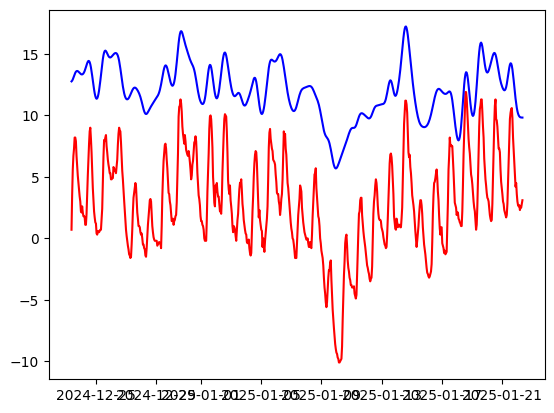

In [5]:
from matplotlib import pyplot as plt
plt.plot(weatherData['ds'], weatherData['y'],color='red')
plt.plot(weatherData['ds'], factoryData['y'],color='blue')
plt.show()

In [6]:
regressor = RandomForestRegressor(random_state=123)
best_mae = float('inf')
best_lag = None
best_predictions = None

for i in range(3, 24):
  forecaster = ForecasterRecursive(
                  regressor = regressor,
                  lags      = i             )
  forecaster.fit(y=factory_trainingData['y'], exog=factory_trainingData['external_param'])
  predictions = forecaster.predict(
                    steps = steps,
                    exog = factory_testData['external_param']
                )
  mae = mean_absolute_error(factory_testData['y'], predictions)
  if(mae < best_mae):
    best_mae = mae
    best_lag = i
    best_predictions = predictions

In [7]:
print(best_mae)

0.9115532021019876


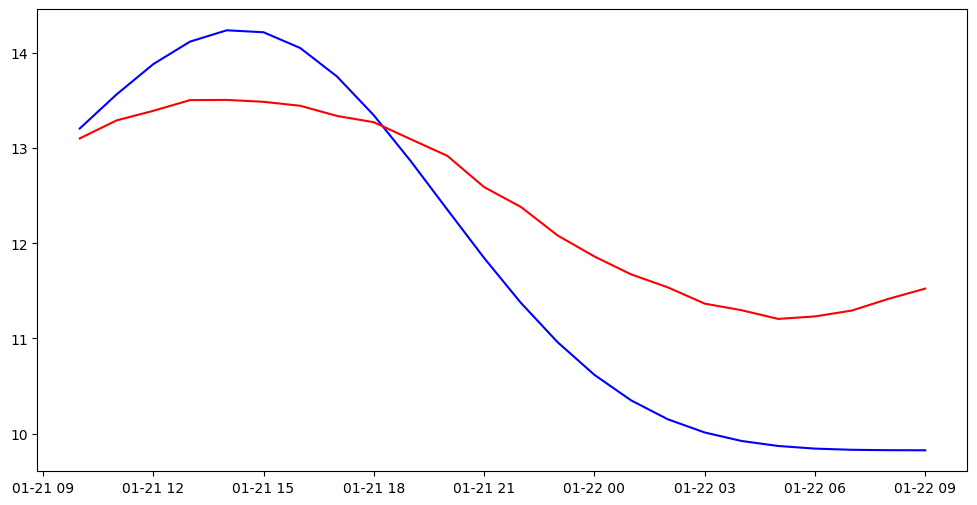

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(factory_testData['ds'], factory_testData['y'],color='blue')
plt.plot(factory_testData['ds'], best_predictions,color='red')
plt.show()